In [44]:
!pip install findspark
# useful to have this code snippet to avoid getting an error in case forgeting 
# to close spark

try:
    sc.stop()
except:
    pass

# Using findspark to find automatically the spark folder
import findspark
findspark.init()

# import python libraries
import random

# initialize
from pyspark.sql import SparkSession 
sc = SparkSession.builder.master("local[*]").getOrCreate()
num_samples = 100000000

def inside(p):
    x, y = random.random(), random.random()
    return x*x + y*y < 1

count = sc.sparkContext.parallelize(range(0, num_samples)).filter(inside).count()
pi = 4 * count / num_samples
print(pi)

You should consider upgrading via the '/opt/app-root/bin/python3 -m pip install --upgrade pip' command.
3.1413136


In [43]:
sc.stop()

In [45]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.amazonaws:aws-java-sdk:1.7.4,org.apache.hadoop:hadoop-aws:2.7.6 pyspark-shell' 

In [46]:
import boto3
s3_endpoint_url = 'http://13.67.138.157:8000'

s3_access_key = 'opendatahub'
s3_secret_key = 'b3BlbmRhdGFodWI='
#s3_bucket = os.environ['BUCKET']
s3_bucket="frauddetection"

# s3_endpoint_url = 'https://play.min.io'
# s3_access_key = 'Q3AM3UQ867SPQQA43P2F'
# s3_secret_key = 'zuf+tfteSlswRu7BJ86wekitnifILbZam1KYY3TG'
# s3_bucket="anonymous"


# Create an S3 client
s3 = boto3.client(service_name='s3',aws_access_key_id = s3_access_key,aws_secret_access_key = s3_secret_key, endpoint_url=s3_endpoint_url)
try:
    s3.create_bucket(Bucket=s3_bucket)
except:
    pass



In [47]:
# Upload to Rook/Ceph in bucket Open and key uploaded/creditcard-sample10k.csv
key = "creditcard-sample10k.csv"
#s3.upload_file(Bucket=s3_bucket, Key=key, Filename="creditcard-sample10k.csv")

#prefix='uploaded/'
#result = s3.list_objects(Bucket=s3_bucket, Prefix=prefix, Delimiter='/')
#print(result)

In [48]:
#Read Data Using Spark
import pyspark
import time
import os
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import boto3
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.metrics import precision_recall_curve,\
                            average_precision_score,\
                            roc_auc_score, roc_curve
        
print("Getting a spark session with the distributed spark cluster running on Openshift ")

Getting a spark session with the distributed spark cluster running on Openshift 


In [49]:
#Spark Session
# spark_cluster_url = f"spark://{os.environ['SPARK_CLUSTER']}:7077"
# print(spark_cluster_url)
spark = SparkSession.builder.appName("odh-pyspark").getOrCreate()
spark = SparkSession.builder.master("local[*]")\
        .appName("odh-pyspark-frauddetection")\
        .getOrCreate()
        
spark.sparkContext.setLogLevel("DEBUG")
print(spark.sparkContext.version)
print("Spark Session Success")

2.4.5
Spark Session Success


In [50]:
#Set the Hadoop configurations to access Ceph S3
hadoopConf=spark.sparkContext._jsc.hadoopConfiguration()
hadoopConf.set("fs.s3a.path.style.access", "true");
hadoopConf.set("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem");
hadoopConf.set("fs.s3a.access.key", s3_access_key) 
hadoopConf.set("fs.s3a.secret.key", s3_secret_key)
hadoopConf.set("fs.s3a.endpoint", s3_endpoint_url)
hadoopConf.set("fs.s3a.connection.ssl.enabled", 'false')

In [56]:
print("Reading from" , s3_bucket)
# data = spark.read.csv('s3a://' + s3_bucket + '/uploaded/creditcard-sample10k.csv',sep=",", header=True)
# val b1 = sc.textFile("s3a://spark-test/test.json")

# data = spark.read.csv('s3a://frauddetection/creditcard-sample10k.csv',sep=",", header=True)
df = spark.read.format("csv").option("header", "true").option("inferSchema", "True").option("mode", "DROPMALFORMED").load(f"s3a://{s3_bucket}/creditcard-sample10k.csv")

# df = data.toPandas()
# df.head()

Reading from frauddetection


In [57]:
print("Total number of credit card transaction rows: %s" % df.count())
### Check the total number of rows with fraud is detected
print("Total number of rows with fraud")
print(df[(df['Class']==1)].count())

Total number of credit card transaction rows: 10000
Total number of rows with fraud
38


In [58]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.externals import joblib

#Order the credit card transaction by transaction time
df.orderBy("Time")

#number of rows in the dataset
n_samples = df.count()
print(n_samples)

#Split into train and test
train_size = 0.75

train_limit = int(n_samples * train_size)
df_train = df.limit(train_limit)     
df_test = df.subtract(df_train) 

#Data Schema
print("Original Data Schema")
df_test.printSchema()

print('Number of train transactions: %s', df_train.count())
print('Number of test  transactions: %s', df_test.count())

#Define features and target variables for convenience.
drop_time_class = ['_c0', 'Time', 'Class']
drop_class=['Class']

#Create Train Datasets
features_train = df_train.drop(*drop_time_class)
target_train = df_train.select("Class")

#Create Test Datasets
features_test = df_test.drop(*drop_time_class)
target_test = df_test.select("Class")

#Create a RondomForest Classifier mode
model = RandomForestClassifier(n_estimators=100, max_depth=4, n_jobs=10)

#Convert to pandas
features_test_pd = features_test.toPandas()
target_test_pd = target_test.toPandas()

features_train_pd = features_train.toPandas()
target_train_pd = target_train.toPandas()

model.fit(features_train_pd, target_train_pd.values.ravel())

pred_train = model.predict(features_train_pd)
pred_test = model.predict(features_test_pd)

pred_train_prob = model.predict_proba(features_train_pd)
pred_test_prob = model.predict_proba(features_test_pd)

print("Number of features")
print(len(model.feature_importances_))

/opt/app-root/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


10000
Original Data Schema
root
 |-- _c0: integer (nullable = true)
 |-- Time: integer (nullable = true)
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = 

In [59]:
%%bash
pip3 install matplotlib

You should consider upgrading via the '/opt/app-root/bin/python3 -m pip install --upgrade pip' command.


0    7475
1      25
Name: Class, dtype: int64
[0, 1]
[0, 1]


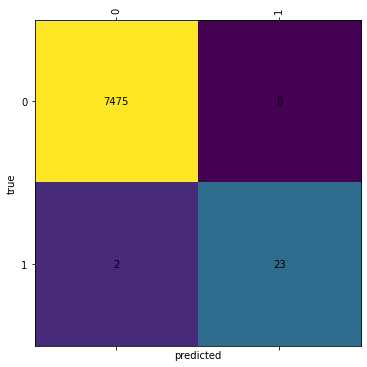

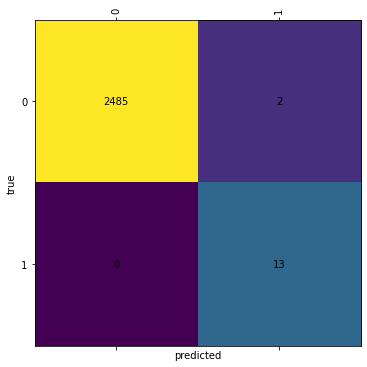

In [60]:
import matplotlib.pylab as plt
import matplotlib.colors
from sklearn.metrics import precision_recall_curve,\
                            average_precision_score,\
                            roc_auc_score, roc_curve,\
                            confusion_matrix, classification_report

def plot_confusion_matrix(train_labels, train_pred):
    fig = plt.figure(figsize=(6,6))
    ax = plt.subplot()

    labels = list(train_labels['Class'].value_counts().index)
    print(labels)

    confusion = confusion_matrix(train_labels, train_pred, labels=labels)
    ax.matshow(np.log(confusion + 1.001))

    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))

    ax.set_xticklabels(labels, rotation=90);
    ax.set_yticklabels(labels);

    for i in range(len(labels)):
        for j in range(len(labels)):        
            ax.text(j, i, confusion[i,j], va='center', ha='center')

    plt.xlabel('predicted')    
    plt.ylabel('true')
    
    return fig

print(target_train_pd['Class'].value_counts())

_=plot_confusion_matrix(target_train_pd, model.predict(features_train_pd))

_=plot_confusion_matrix(target_test_pd, model.predict(features_test_pd))

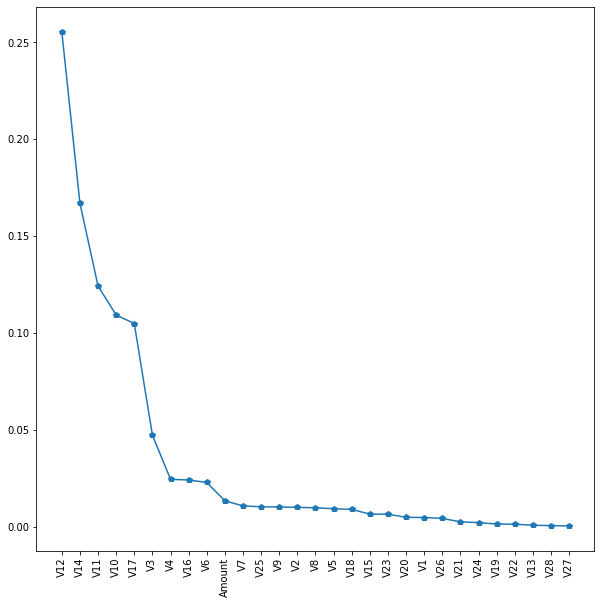

In [61]:
%matplotlib inline
import operator
import matplotlib.pylab as plt

feat_imp = sorted(zip(features_train_pd.columns, model.feature_importances_), key=operator.itemgetter(1), reverse=True)
plt.figure(figsize=(10,10))
plt.plot([i[0] for i in feat_imp], [i[1] for i in feat_imp], 'p-')
_ = plt.xticks(rotation=90)

In [62]:
#Define features and target variables for convenience.
## From the graph we only want seven important features V3,V4,V10,V11,V12,V14,V17
drop_time_class = ['_c0', 'Time', 'Class','V1','V2','V5','V6','V7','V8','V9','V13','V15','V16','V18','V19','V20','V21','V22','V23','V24','V25','V26','V27','V28']
drop_class=['Class']


features_train = df_train.drop(*drop_time_class)
target_train = df_train.select("Class")

features_test = df_test.drop(*drop_time_class)
target_test = df_test.select("Class")
features_test.printSchema()

model = RandomForestClassifier(n_estimators=200, max_depth=6, n_jobs=10, class_weight='balanced')
                               
#Convert to pandas
features_test_pd = features_test.toPandas()
target_test_pd = target_test.toPandas()

features_train_pd = features_train.toPandas()
target_train_pd = target_train.toPandas()

model.fit(features_train_pd, target_train_pd.values.ravel())

pred_train = model.predict(features_train_pd)
pred_test = model.predict(features_test_pd)

pred_train_prob = model.predict_proba(features_train_pd)
pred_test_prob = model.predict_proba(features_test_pd)

print("Number of features")
print(len(model.feature_importances_))
  
#save mode in filesystem
joblib.dump(model, 'model.pkl') 

root
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- Amount: double (nullable = true)

Number of features
8


['model.pkl']

[0, 1]
[0, 1]


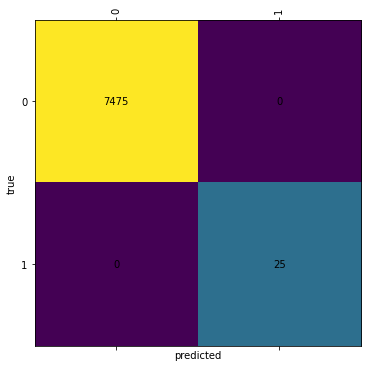

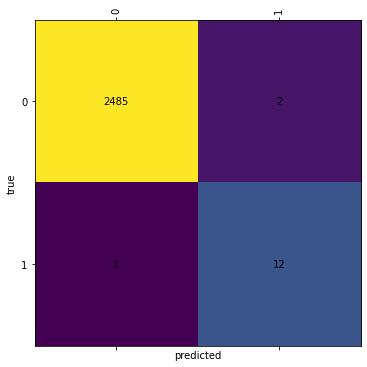

In [63]:
_ = plot_confusion_matrix(target_train_pd, model.predict(features_train_pd))

_ = plot_confusion_matrix(target_test_pd, model.predict(features_test_pd))

In [64]:
import json
import pandas as pd
import numpy as np
import time


df_test_pandas = df_test.toPandas()
fraudTest = df_test_pandas.loc[df_test_pandas['Class']== 1]
notFraudTest = df_test_pandas.loc[df_test_pandas['Class']== 0]

fraudTestFeatures = fraudTest.drop(columns=['Time','Class', '_c0','V1','V2','V5','V6','V7','V8','V9','V13','V15','V16','V18','V19','V20','V21','V22','V23','V24','V25','V26','V27','V28'])
notFraudTestFeatures = notFraudTest.drop(columns=['Time','Class', '_c0','V1','V2','V5','V6','V7','V8','V9','V13','V15','V16','V18','V19','V20','V21','V22','V23','V24','V25','V26','V27','V28'])

for index, row in fraudTestFeatures.iterrows():
    data = row
    rowdf = pd.DataFrame([data.tolist()], columns = ['V3','V4','V10','V11','V12','V14','V17','Amount'])
    print(model.predict(rowdf))
    time.sleep(2)


[1]
[1]
[1]
[1]
[1]
[1]
[1]
[0]
[1]
[1]
[1]
[1]
[1]


In [65]:
import boto3

key = "uploaded/model.pkl"
s3.upload_file(Bucket=s3_bucket, Key=key, Filename="model.pkl")
prefix='uploaded/'
result = s3.list_objects(Bucket=s3_bucket, Prefix=prefix, Delimiter='/')
print(result)

{'ResponseMetadata': {'RequestId': '16263C0322A68CC3', 'HostId': '', 'HTTPStatusCode': 200, 'HTTPHeaders': {'accept-ranges': 'bytes', 'content-length': '635', 'content-security-policy': 'block-all-mixed-content', 'content-type': 'application/xml', 'server': 'MinIO/RELEASE.2020-07-02T00-15-09Z', 'vary': 'Origin', 'x-amz-request-id': '16263C0322A68CC3', 'x-xss-protection': '1; mode=block', 'date': 'Wed, 29 Jul 2020 13:25:02 GMT'}, 'RetryAttempts': 0}, 'IsTruncated': False, 'Marker': '', 'Contents': [{'Key': 'uploaded/model.pkl', 'LastModified': datetime.datetime(2020, 7, 29, 13, 25, 1, 968000, tzinfo=tzlocal()), 'ETag': '"5ac43106a8cc1767f0ea6b809e363c8d"', 'Size': 247582, 'StorageClass': 'STANDARD', 'Owner': {'DisplayName': '', 'ID': '02d6176db174dc93cb1b899f7c6078f08654445fe8cf1b6ce98d8855f66bdbf4'}}], 'Name': 'frauddetection', 'Prefix': 'uploaded/', 'Delimiter': '/', 'MaxKeys': 50000, 'EncodingType': 'url'}


In [71]:
%%bash
oc login --insecure-skip-tls-verify -u kubeadmin -p fq66o-KsVBU-cnKBU-xLpqd https://api.crc.testing:6443
oc project odhk

Login successful.

You have access to 72 projects, the list has been suppressed. You can list all projects with 'oc projects'

Using project "default".
Welcome! See 'oc help' to get started.
Now using project "odhk" on server "https://api.crc.testing:6443".
